In [1]:
import os
import sys
import gzip
import shutil
import tempfile
import math
import glob
import scipy
import sympy
from sympy.abc import x
import datetime as dt
import xarray as xr
import numpy as np
from scipy import stats
from scipy.signal import correlate
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
# import radar_calibration as rc
# sys.path.append('G:\Mi unidad\03.PROGRAMAS\utils_gfat_old3')
# from readers import backscatter_lidar
sys.path.append(r'G:\Mi unidad\03.PROGRAMAS')
# sys.path.append(r'/home/mopsmap/Escritorio/Marta/03.PROGRAMAS')
from utils_gfat import lidar
from utils_gfat_old3 import cod_lidar
sys.path.append(r'G:\Mi unidad\03.PROGRAMAS\utils_gfat\lidar_processing')
# sys.path.append(r'/home/mopsmap/Escritorio/Marta/03.PROGRAMAS/utils_gfat_old3/lidar_processing')
from lidar_processing import helper_functions
#import lidar
import netCDF4 as nc
import glob
from scipy.signal import savgol_filter

# import cod_lidar

In [2]:
# Función de cálculo de la COD

def COD_calculation(maindir, day, month, year, number_of_channel, base, top, figdir):

    # 7.Se cargan los datos del LIDAR
    # maindir_LIDAR = '/home/mopsmap/Escritorio/Marta/00.INVESTIGACION/DATOS/MULHACEN/1a/2020/01/15'
    #             maindir_LIDAR = os.path.join(maindir_root,Time_month[0:4], Time_month[5:7], str(_day))
    LIDARfile = 'mhc_1a_Prs_*.nc'
    LIDARfileDC = 'mhc_1a_Pdc_*.nc'
    filedir = os.path.join(maindir, year, month, day)
    LIDARpath = os.path.join(filedir, LIDARfile)
    LIDARpathDC = os.path.join(filedir, LIDARfileDC)
    
    hours = np.arange(0,24)
#     minutes = ['00','10','20','30','40','50']
    minutes = ['00','05','10','15','20','25','30','35','40','45','50','55']
    
    Time_month = year + '-' + month

    # Corregir medidas LIDAR con la corriente oscura
    
    if (os.path.isdir(filedir)==True):

        correct_LIDAR = lidar.preprocessing(LIDARpath, LIDARpathDC, ini_date=None, end_date=None, ini_range=None, end_range=None, percentage_required=80, channels=[0])
        
#         ini_date=None, end_date=None, ini_range=None, end_range=None,
#                   percentage_required=80, channels='all'
        
        print(correct_LIDAR)
#         print('Longitudes de onda:', correct_LIDAR['wavelength'].values)

        COD_serie = []
        CBH_serie = []
        CTH_serie = []
        date_serie = []

        for j,_hour in enumerate(hours):
            for i,_minute in enumerate(minutes[0:len(minutes)-1]):

                #set height range in meters
                zref1 = 0
                zref2 = 20000

                startTime = Time_month + '-' + day + ' ' + str(hours[j]) + ':' + minutes[i]
                stopTime = Time_month + '-' + day + ' ' + str(hours[j]) + ':' + minutes[i+1]
                filename_date = year + month + day + str(hours[j]) + minutes[i]

                initime = pd.to_datetime(startTime,format='%Y-%m-%d %H:%M')
                endtime = pd.to_datetime(stopTime,format='%Y-%m-%d %H:%M')
    #             signal_to_profile = 'correct_LIDAR.corrected_rcs_' + number_of_channel
                signal_to_profile = 'corrected_rcs_' + number_of_channel 
                profile = correct_LIDAR[signal_to_profile].sel(time=slice(initime, endtime), range=slice(zref1, zref2))

                if (str(profile.mean().values) == 'nan'):

                    COD = np.nan;
                    zref1 = zref2 = np.nan
    #                 print(COD)

    #                 f_CBH.write(str(zref1) + '\n')
    #                 f_COD.write(str(COD) + '\n')

                    COD_serie = np.append(COD_serie,COD)
                    CBH_serie = np.append(CBH_serie,zref1)
                    CTH_serie = np.append(CTH_serie,zref2)
                    date_serie = np.append(date_serie,startTime)

                else:

                    # Alturas sobre el nivel del mar del LIDAR

                    heights = profile.range.values + 680

                    # Parámetros de atmósfera standard

                    T = np.ones(heights.size)*np.nan
                    P = np.ones(heights.size)*np.nan
                    for i,_height in enumerate(heights):
                        sa = helper_functions.standard_atmosphere(_height)
                        P[i]  = sa[0]
                        T[i]  = sa[1]

                    # Alpha molecular y extinción teóricas

                    betamol = np.ones(heights.size)*np.nan
                    alfamol = np.ones(heights.size)*np.nan
                    for i,_height in enumerate(heights):
                        betamol[i] = helper_functions.molecular_backscatter(532, P[i], T[i])  
                        alfamol[i] = helper_functions.molecular_extinction(532, P[i], T[i])  


                    # Transmitancia: Integral de la definición por la resolución en altura.

                    transmittance = np.exp(-2*scipy.integrate.cumtrapz(alfamol, initial = alfamol[0])*(heights[1] - heights[0]))

                    # Cumptrapz
                    # scipy.integrate.cumtrapz(y, x=None, dx=1.0, axis=-1, initial=None)
                    # Beta molecular atenuada teórica

                    beta_molecular_att = betamol*np.resize(transmittance, heights.shape) 

                    zref1 = base
                    zref2 = top

                    mprofile = profile.mean(axis=0)
                    smprofile = savgol_filter(mprofile, 51, 1) # window size 51, polynomial order 3


                    # Cálculo de los límites de la nube. Implementación automática de los límites de integración

                    stat_diff = [];
                    for i,_height in enumerate(heights):        
                        # Antes de llegar a la nube
                        idx = np.logical_and(heights >= heights[i], heights <= heights[i] + 500)   
                        stat_beta=scipy.stats.linregress(heights[idx],beta_molecular_att[idx])
                        stat_mprofile=scipy.stats.linregress(heights[idx],mprofile[idx])
                    #     print('Altura:',heights[i])
                    #     print('Pendiente b_att:',stat_beta.slope)
                    #     print('Pendiente R_fit:',stat_rayleigh.slope)
                        stat_diff = np.append(stat_diff,(stat_beta.slope - stat_mprofile.slope))

                    stat_diff_sel_idx = np.logical_and(heights>=zref1, heights<=zref2)
                    stat_diff_sel = stat_diff[stat_diff_sel_idx]


                    
                    
#                     stat_diff_der_vector = []
#                     cloud_range = []                    
#                     for i,_height in enumerate(stat_diff_sel):
#                         idx_2 = np.logical_and(heights >= heights[stat_diff_sel_idx][i], heights <= heights[stat_diff_sel_idx][i] + 500)
#                         stat_diff_der=scipy.stats.linregress(heights[idx_2],stat_diff[idx_2])
#                         stat_diff_der_vector = np.append(stat_diff_der_vector,stat_diff_der.slope)
# #                         if (math.fabs(stat_diff_der.slope) > 2):
# #                             cloud_range = np.append(cloud_range, heights[stat_diff_sel_idx][i])

#                     diff_consec = []
#                     for i,_height in enumerate (stat_diff_der_vector[0:len(stat_diff_der_vector)-1]):
#                         diff = stat_diff_der_vector[i+1] - stat_diff_der_vector[i]
#                         diff_consec = np.append(diff_consec, diff)
                        
                    der_vector = []
                    cloud_range = []
                    for i,_ejemplo in enumerate(stat_diff_sel[0:(len(stat_diff_sel)-1)]):
            #             der_vector = np.append(der_vector,stat_diff_sel[i]-stat_diff_sel.mean())
                        der_vector = np.append(der_vector,stat_diff_sel[i])
                        der = stat_diff_sel[i]#-np.nanmedian(stat_diff_sel)
                        if (math.fabs(der) >= 1500):
                            cloud_range = np.append(cloud_range, heights[stat_diff_sel_idx][i])

                    if (cloud_range == []):

                        COD = np.nan;
                        zref1 = zref2 = np.nan
    #                     print(COD)

                        COD_serie = np.append(COD_serie,COD)
                        CBH_serie = np.append(CBH_serie,zref1)
                        CTH_serie = np.append(CTH_serie,zref2)
                        date_serie = np.append(date_serie,startTime)            

                    else:

                        zref1 = cloud_range[0]
                        zref2 = cloud_range[len(cloud_range)-1]
                        
#                         index_zref1 = list(heights[stat_diff_sel_idx]).index(zref1)
# #                         index_zref2 = list(heights[stat_diff_sel_idx]).index(zref2)

#                         cases_bf = []
#                         cases_af = []
#                         for i in np.arange(1,150):
# #                             if (math.fabs(der_vector[index_zref2+i]) < 20):
# #                                 cases_af = np.append(cases_af,index_zref2+i)
#                             if (math.fabs(der_vector[index_zref1-i]) < 20):    
#                                 cases_bf = np.append(cases_bf,index_zref1-i)
                                
# #                         print(cases_bf)  
# #                         print(cases_af)
                                
#                         zref1 = heights[stat_diff_sel_idx][int(cases_bf[0])]
# #                         zref2 = heights[stat_diff_sel_idx][int(cases_af[0])]
        #                         plt.figure(figsize=[15,10])
        #                         plt.plot(der_vector)


        #                         print('CBH:',zref1)
        #                         print('CTH:',zref2)
        #                         print('STD:',np.std(stat_diff_sel))

                        # Antes de llegar a la nube
                        idx_bf = np.logical_and(heights >= (heights[list(heights).index(zref1)+50] - 500), heights <= heights[list(heights).index(zref1)+50])
                        beta_molecular_att_bf = beta_molecular_att[idx_bf].mean()
                        profile_rayleigh_bf = smprofile[idx_bf].mean()
                        ratio_bf  = beta_molecular_att_bf/profile_rayleigh_bf
                        rayleigh_fit_bf = smprofile*ratio_bf

                        # Después de pasar la nube
                        idx_af = np.logical_and(heights >= (heights[list(heights).index(zref2)+50]), heights <= heights[list(heights).index(zref2)+50] + 500)
                        beta_molecular_att_af = beta_molecular_att[idx_af].mean()
                        profile_rayleigh_af = smprofile[idx_af].mean()
                        ratio_af = beta_molecular_att_af/profile_rayleigh_af
                        rayleigh_fit_af = smprofile*ratio_af

                        COD = -2*np.log(ratio_bf/ratio_af)

                        if (COD<0):
                            COD = np.nan
    #                         print(COD)

                        if (COD>0):
                            COD_serie = np.append(COD_serie,COD)
                            CBH_serie = np.append(CBH_serie,zref1)
                            CTH_serie = np.append(CTH_serie,zref2)
                            date_serie = np.append(date_serie,startTime)

    #                         if (COD >= 0.5 and COD <= 2):

#                             fig = plt.figure(figsize=[15,10])
#                             plt.plot(heights/1000, rayleigh_fit_bf, 'k', label='Normaliced RCS Below', linewidth=3)
#                             plt.plot(heights/1000, rayleigh_fit_af, 'r', label='Normaliced RCS Above', linewidth=3)
#             #                 plt.plot(heights[stat_diff>0], rayleigh_fit_bf[stat_diff>0], 'k*')
#             #                 plt.plot(heights[stat_diff<0], rayleigh_fit_bf[stat_diff<0], 'b*')
#             #                 plt.plot(heights[stat_diff>0], rayleigh_fit_af[stat_diff>0], 'c*')                
#             #                 plt.plot(heights[stat_diff<0], rayleigh_fit_af[stat_diff<0], 'm*')                
#                             plt.plot(heights/1000,beta_molecular_att, 'g', label=r'$\beta_{att}^{mol}$', linewidth=3, markersize=12)
#                             plt.plot(heights[list(heights).index(zref1)+60]/1000,rayleigh_fit_bf[list(heights).index(zref1)+60], 'b*', label='Cloud Boundaries', linewidth=2, markersize=12)
#                             plt.plot(heights[list(heights).index(zref2)+60]/1000,rayleigh_fit_af[list(heights).index(zref2)+60], 'b*', linewidth=2, markersize=12)
#                             plt.grid()
#                             ax=plt.axes()
#                             ax.tick_params(axis ='both', which ='both', length = 8)
#                             ax.spines['bottom'].set_linewidth(3)
#                             ax.spines['left'].set_linewidth(3)
#                             ax.spines['top'].set_visible(3)
#                             ax.spines['right'].set_visible(3)
#                             plt.xticks(fontsize=16)
#                             plt.yticks(fontsize=16)
#                             plt.yscale('log')
#                             plt.ylim(1e-8,1e-4)
#                             plt.title(startTime + '-' + stopTime[len(stopTime)-5:len(stopTime)] + ' UTC' + ' COD = '+ '{:.2f}'.format(COD), fontsize=14, fontweight='bold')
#                             plt.xlabel('Height (km)', fontsize=12, fontweight='bold')
#                             plt.ylabel('RCS_532(a.u.)', fontsize=14, fontweight='bold')
#                             plt.legend(fontsize=12)
#                             figpath = os.path.join(figdir, 'quicklook_'+ filename_date +'.png')
#                             print(figpath)
#                             plt.savefig(figpath, dpi=400)
                            
#                             fig = plt.figure(figsize=[15,10])
#                             plt.plot(heights[stat_diff_sel_idx]/1000,stat_diff[stat_diff_sel_idx])
#                             plt.plot(heights[stat_diff_sel_idx][list(heights[stat_diff_sel_idx]).index(zref1)]/1000,stat_diff[stat_diff_sel_idx][list(heights[stat_diff_sel_idx]).index(zref1)], 'b*', label='Cloud Boundaries', linewidth=2, markersize=12)
#                             plt.plot(heights[stat_diff_sel_idx][list(heights[stat_diff_sel_idx]).index(zref2)]/1000,stat_diff[stat_diff_sel_idx][list(heights[stat_diff_sel_idx]).index(zref2)], 'b*', linewidth=2, markersize=12)
#                             plt.grid()
#                         fig = plt.figure(figsize=[15,10])
#                         plt.plot(stat_diff[stat_diff_sel_idx])
                        
#                         fig = plt.figure(figsize=[15,10])
#                         plt.plot(stat_diff_der_vector,'r')   
                        
#                         fig = plt.figure(figsize=[15,10])
#                         plt.plot(diff_consec,'g') 
                        
    else:
        print('File not found:',day+month+year)
        COD_serie = []
        CBH_serie = []
        CTH_serie = []
        date_serie = []
    
    
    return COD_serie, CBH_serie, CTH_serie, date_serie

    

In [3]:
# # maindir_root = 'Y:\datos\MULHACEN\1a'
# maindir_root = 'Y:\datos\MULHACEN\\1a'
maindir_root = 'Y:\datos\MULHACEN\\1a'
maindir = '/home/mopsmap/Escritorio/Marta/00.INVESTIGACION/DATOS/MULHACEN/1a/2020/01/15'
figdir = 'G:\Mi unidad\\00.INVESTIGACION\CONGRESOS\ELC_CONGRESS\IMAGES\RAYLEIGH_FIT'

COD = []
CBH = []
CTH = []
date_tot = []

COD_daymean = []
CBH_daymean = []
CTH_daymean = []
datemean = []

# maindir_root = '/media/nas_gfat/datos/MULHACEN/1a'
# maindir = '/home/mopsmap/Escritorio/Marta/00.INVESTIGACION/DATOS/MULHACEN/1a/2020/01/15'
# figdir = '/home/mopsmap/Escritorio/Marta/00.INVESTIGACION/CONGRESOS/ELC_CONGRESS/IMAGES/RAYLEIGH_FIT'
for i in np.arange(1,32):

    if i < 10:
        day = '0'+str(i)
    elif i>= 10:
        day = str(i)
    month = '12'
    year = '2019'
    number_of_channel = '00'
    base_clean = 5000.
    top_clean = 14000.
    # 1064: 06
    # 532: 00, 01, 02, 03
    # COD, CBH = cod_lidar.COD_calculation(maindir_root, day, month, year, number_of_channel)
    if os.path.isdir(os.path.join(maindir_root, year, month, day))==True:
        COD_day, CBH_day, CTH_day, date_tot_day = COD_calculation(maindir_root, day, month, year, number_of_channel, base_clean, top_clean, figdir)
    
        COD = np.append(COD,COD_day)
        CBH = np.append(CBH,CBH_day)
        CTH = np.append(CTH,CTH_day)
        date_tot = np.append(date_tot,date_tot_day)
        
        if COD !=[]:
        
        
            COD_daymean = np.append(COD_daymean, np.nanmean(COD_day))
            CBH_daymean = np.append(CBH_daymean, np.nanmean(CBH_day))
            CTH_daymean = np.append(CTH_daymean, np.nanmean(CTH_day))
            datemean = np.append(datemean, date_tot_day[0])

Perform preprocessing
['Y:\\datos\\MULHACEN\\1a\\2019\\12\\02\\mhc_1a_Prs_20191202.nc']
['Y:\\datos\\MULHACEN\\1a\\2019\\12\\02\\mhc_1a_Pdc_20191202_0911.nc']
End Preprocessing Succesfully
<xarray.Dataset>
Dimensions:              (n_chan: 1, nv: 2, range: 16380, time: 275)
Coordinates:
  * time                 (time) datetime64[ns] 2019-12-02T09:11:35 ... 2019-12-02T14:58:34
  * range                (range) float32 7.5 15.0 22.5 ... 122842.5 122850.0
  * n_chan               (n_chan) int32 0
Dimensions without coordinates: nv
Data variables:
    time_bnds            (time, nv) datetime64[ns] dask.array<chunksize=(275, 2), meta=np.ndarray>
    lat                  float32 -3.61
    lon                  float32 37.16
    altitude             float32 680.0
    wavelength           (n_chan) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    telescope            (n_chan) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    polarization         (n_chan) int16 dask.array<chunksize=(1,)

Perform preprocessing
['Y:\\datos\\MULHACEN\\1a\\2019\\12\\12\\mhc_1a_Prs_20191212.nc']
['Y:\\datos\\MULHACEN\\1a\\2019\\12\\12\\mhc_1a_Pdc_20191212_0829.nc', 'Y:\\datos\\MULHACEN\\1a\\2019\\12\\12\\mhc_1a_Pdc_20191212_1804.nc']
End Preprocessing Succesfully
<xarray.Dataset>
Dimensions:              (n_chan: 1, nv: 2, range: 16380, time: 691)
Coordinates:
  * time                 (time) datetime64[ns] 2019-12-12T08:29:47.999999744 ... 2019-12-12T20:00:21
  * range                (range) float32 7.5 15.0 22.5 ... 122842.5 122850.0
  * n_chan               (n_chan) int32 0
Dimensions without coordinates: nv
Data variables:
    time_bnds            (time, nv) datetime64[ns] dask.array<chunksize=(691, 2), meta=np.ndarray>
    lat                  float32 -3.61
    lon                  float32 37.16
    altitude             float32 680.0
    wavelength           (n_chan) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    telescope            (n_chan) int32 dask.array<chunksize=(1,), me

Perform preprocessing
['Y:\\datos\\MULHACEN\\1a\\2019\\12\\19\\mhc_1a_Prs_20191219.nc']
['Y:\\datos\\MULHACEN\\1a\\2019\\12\\19\\mhc_1a_Pdc_20191219_0919.nc']
End Preprocessing Succesfully
<xarray.Dataset>
Dimensions:              (n_chan: 1, nv: 2, range: 16380, time: 142)
Coordinates:
  * time                 (time) datetime64[ns] 2019-12-19T09:19:02 ... 2019-12-19T11:37:41
  * range                (range) float32 7.5 15.0 22.5 ... 122842.5 122850.0
  * n_chan               (n_chan) int32 0
Dimensions without coordinates: nv
Data variables:
    time_bnds            (time, nv) datetime64[ns] dask.array<chunksize=(142, 2), meta=np.ndarray>
    lat                  float32 -3.61
    lon                  float32 37.16
    altitude             float32 680.0
    wavelength           (n_chan) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    telescope            (n_chan) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    polarization         (n_chan) int16 dask.array<chunksize=(1,)

In [10]:
# COD_monthly = []
# CBH_monthly = []
# CTH_monthly = []
# COD_monthly = []
# COD_monthly = np.append(COD_monthly, np.nanmean(COD_daymean))
# CBH_monthly = np.append(CBH_monthly, np.nanmean(CBH_daymean))
# CTH_monthly = np.append(CTH_monthly, np.nanmean(CTH_daymean))
# date_monthly = np.append(date_monthly, np.nanmean(datemean))

In [4]:
filedir = 'G:\Mi unidad\\00.INVESTIGACION\CONGRESOS\ELC_CONGRESS\Files_lidar'

file_COD = 'COD_lidar_2019.txt'
file_CBH = 'CBH_lidar_2019.txt'
file_CTH = 'CTH_lidar_2019.txt'
file_date = 'date_lidar_2019.txt'

file_COD_meanday = 'COD_lidar_2019_meanday.txt'
file_CBH_meanday = 'CBH_lidar_2019_meanday.txt'
file_CTH_meanday = 'CTH_lidar_2019_meanday.txt'
file_date_meanday = 'date_lidar_2019_meanday.txt'

file_COD_monthly = 'COD_lidar_2019_monthly.txt'
file_CBH_monthly = 'CBH_lidar_2019_monthly.txt'
file_CTH_monthly = 'CTH_lidar_2019_monthly.txt'
# file_date_monthly = 'date_lidar_2019_monthly.txt'

f_COD = open(os.path.join(filedir,file_COD),'a')
f_CBH = open(os.path.join(filedir,file_CBH),'a')
f_CTH = open(os.path.join(filedir,file_CTH),'a')
f_date = open(os.path.join(filedir,file_date),'a')

f_COD_meanday = open(os.path.join(filedir,file_COD_meanday),'a')
f_CBH_meanday = open(os.path.join(filedir,file_CBH_meanday),'a')
f_CTH_meanday = open(os.path.join(filedir,file_CTH_meanday),'a')
f_date_meanday = open(os.path.join(filedir,file_date_meanday),'a')

f_COD_monthly = open(os.path.join(filedir,file_COD_monthly),'a')
f_CBH_monthly = open(os.path.join(filedir,file_CBH_monthly),'a')
f_CTH_monthly = open(os.path.join(filedir,file_CTH_monthly),'a')
# f_date_monthly = open(os.path.join(filedir,file_date_monthly),'a')

for i,_COD in enumerate(COD):
    f_COD.write(str(COD[i]) + '\n')
    f_CBH.write(str(CBH[i]) + '\n')
    f_CTH.write(str(CTH[i]) + '\n')
    f_date.write(date_tot[i] + '\n')

for i,_COD in enumerate(COD_daymean):
    f_COD_meanday.write(str(COD_daymean[i]) + '\n')
    f_CBH_meanday.write(str(CBH_daymean[i]) + '\n')
    f_CTH_meanday.write(str(CTH_daymean[i]) + '\n')
    f_date_meanday.write(datemean[i] + '\n')


f_COD_monthly.write(str(np.nanmean(COD_daymean)) + '\n')
f_CBH_monthly.write(str(np.nanmean(CBH_daymean)) + '\n')
f_CTH_monthly.write(str(np.nanmean(CTH_daymean)) + '\n')
# f_date_monthly.write(datemean[i] + '\n')
    
f_COD.close
f_CBH.close
f_CTH.close
f_date.close
f_COD_meanday.close
f_CBH_meanday.close
f_CTH_meanday.close
f_date_meanday.close
f_COD_monthly.close
f_CBH_monthly.close
f_CTH_monthly.close

<function TextIOWrapper.close()>

Text(0.5, 0, 'COD')

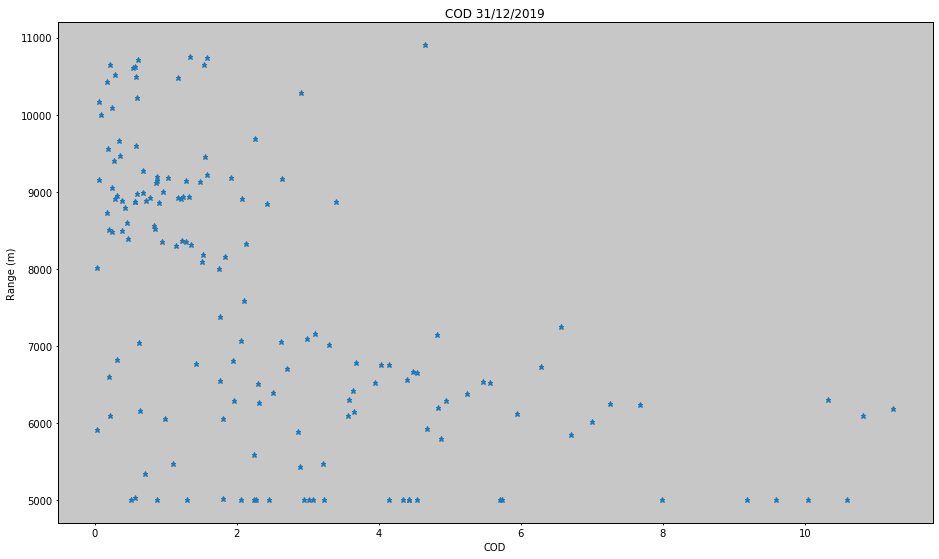

In [5]:

fig = plt.figure(figsize=[15,10])
plt.plot(COD,CBH,'*')
plt.title('COD ' + day+'/'+month+'/'+year )
plt.ylabel('Range (m)')
plt.xlabel('COD')
# figpath = os.path.join(figdir, 'COD_05min_'+ day+month+year +'.png')
# print(figpath)
# plt.savefig(figpath, dpi=400)

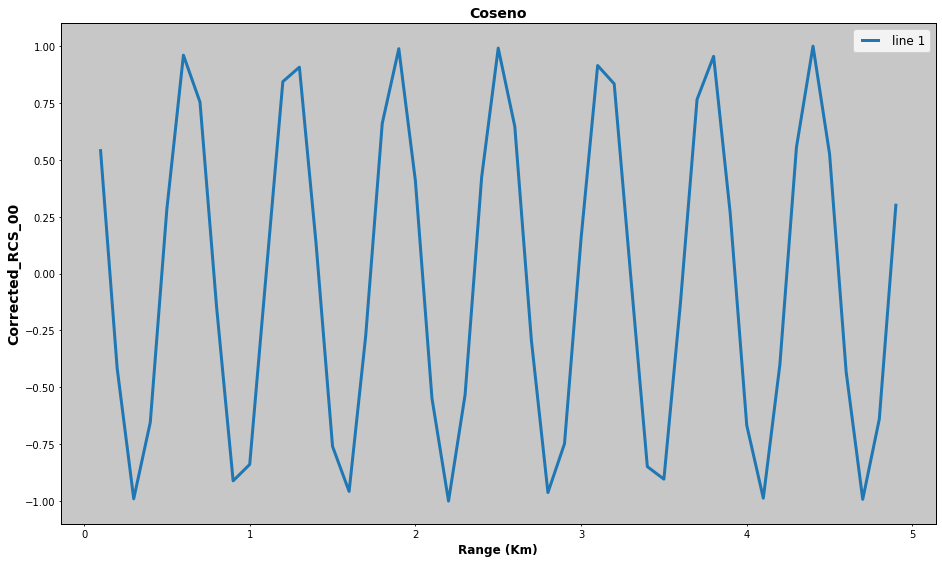

In [19]:

x = np.arange(1,50)

y = []
for i in x:
    y = np.append(y,math.cos(i))
    
fig = plt.figure(figsize=[15,10])
plt.plot(x/10,y, label='line 1', linewidth=3)
plt.title('Coseno', fontsize=14, fontweight='bold')
plt.xlabel('Range (Km)', fontsize=12, fontweight='bold')
plt.ylabel('Corrected_RCS_00', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)

In [52]:
def COD_calculation_monthly(maindir, month, year, number_of_channel, base, top, figdir):
    
    COD_monthly_serie = []
    CBH_monthly_serie = []
    
    day = np.arange(1,32)

    for _day in day:
        
        if (_day<10):
            
            _day = '0' + str(_day)
            COD_day = []
            CBH_day = []
            COD_day, CBH_day = COD_calculation(maindir, _day, month, year, number_of_channel, base, top, figdir)
            COD_monthly_serie = np.append(COD_monthly_serie,COD_day)
            CBH_monthly_serie = np.append(CBH_monthly_serie,CBH_day)
            print('Done:',_day)
            
        elif (_day>=10):
            
            _day = str(_day)
            COD_day = []
            CBH_day = []
            COD_day, CBH_day = COD_calculation(maindir, _day, month, year, number_of_channel, base, top, figdir)
            COD_monthly_serie = np.append(COD_monthly_serie,COD_day)
            CBH_monthly_serie = np.append(CBH_monthly_serie,CBH_day)
            print('Done:',_day)
            
    return COD_monthly_serie, CBH_monthly_serie
        

In [ ]:
maindir_root = 'Y:\datos\MULHACEN\\1a'
maindir = '/home/mopsmap/Escritorio/Marta/00.INVESTIGACION/DATOS/MULHACEN/1a/2020/01/15'
figdir = 'G:\Mi unidad\\00.INVESTIGACION\CONGRESOS\ELC_CONGRESS\IMAGES\RAYLEIGH_FIT'
month = '09'
year = '2019'
number_of_channel = '00'
base_clean = 6000.
top_clean = 14000.
COD_month, CBH_month = cod_lidar.COD_calculation_monthly(maindir_root,month,year,number_of_channel, base_clean, top_clean, figdir)

In [ ]:
def date_COD_calculation(maindir, dateini, dateend, number_of_channel):
   """
    Function to calculate COD and CBH series in a specific period in terms of LIDAR data.
    Inputs:
    - maindir: path where 1a-level LIDAR data are located.
    - Initial date [yyyy-mm-dd] (str). 
    - Final date [yyyy-mm-dd] (str).
        
    Outputs: 
    - COD and CBH data string by periods of 10 minutes.
    """        

    if maindir == 'GFATserver':
        maindir = '/mnt/NASGFAT/datos/RPG-HATPRO/Data'       

    inidate = dt.datetime.strptime(dateini, '%Y%m%d')
    enddate = dt.datetime.strptime(dateend, '%Y%m%d')

    period = enddate - inidate
    
    COD_date_serie = []
    CBH_date_serie = []
    
    for _day in range(period.days + 1):
        current_date = inidate + dt.timedelta(days=_day)  
        COD_day = []
        CBH_day = []
        COD_day, CBH_day = COD_calculation(maindir,'%02d' % current_date.day, '%02d' % current_date.month, '%d' % current_date.year, number_of_channel)
        COD_date_serie = np.append(COD_date_serie,COD_day)
        CBH_date_serie = np.append(CBH_date_serie,CBH_day)
        print('Done:',current_date.day+current_date.month+current_date.year)
        
    return COD_date_serie, CBH_date_serie
        

In [18]:
maindir_root = 'Y:\datos\MULHACEN\\1a'
dateini = '20180905'
dateend = '20181231'
number_of_channel = '06'
COD, CBH = cod_lidar.date_COD_calculation(maindir_root, dateini, dateend, number_of_channel)
plt.plot(CBH,COD)

['Y:\\datos\\MULHACEN\\1a\\2018\\09\\05\\mhc_1a_Prs_20180905.nc']
['Y:\\datos\\MULHACEN\\1a\\2018\\09\\05\\mhc_1a_Pdc_20180905_0740.nc']
[0 1 2 3 4 5 6 7 8 9]


RuntimeError: NetCDF: HDF error

In [4]:
COD

array([nan, nan, nan, ..., nan, nan, nan])

In [5]:
CBH

array([nan, nan, nan, ..., nan, nan, nan])

In [16]:
filedir = 'G:\\Mi unidad\\00.INVESTIGACION\\CONGRESOS\\ELC_CONGRESS'
f_COD = open(os.path.join(filedir,'COD_LIDAR_06_2018.txt'),'a')
f_CBH = open(os.path.join(filedir,'CBH_LIDAR_06_2018.txt'),'a')

for i,_CBH in enumerate(CBH):
    f_COD.write(str(COD[i]) + '\n')
    f_CBH.write(str(CBH[i]) + '\n')
    
f_COD.close
f_CBH.close

<function TextIOWrapper.close()>

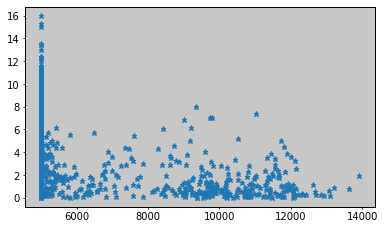

In [17]:
plt.plot(CBH,COD,'*')

In [ ]:
########################################################################################33
##########################################################################################33333333
